# Test DRDV Policy with high Isp

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/PCM/PCM_v2/Projects/AAS-19-293/RPPO_engine_failure


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


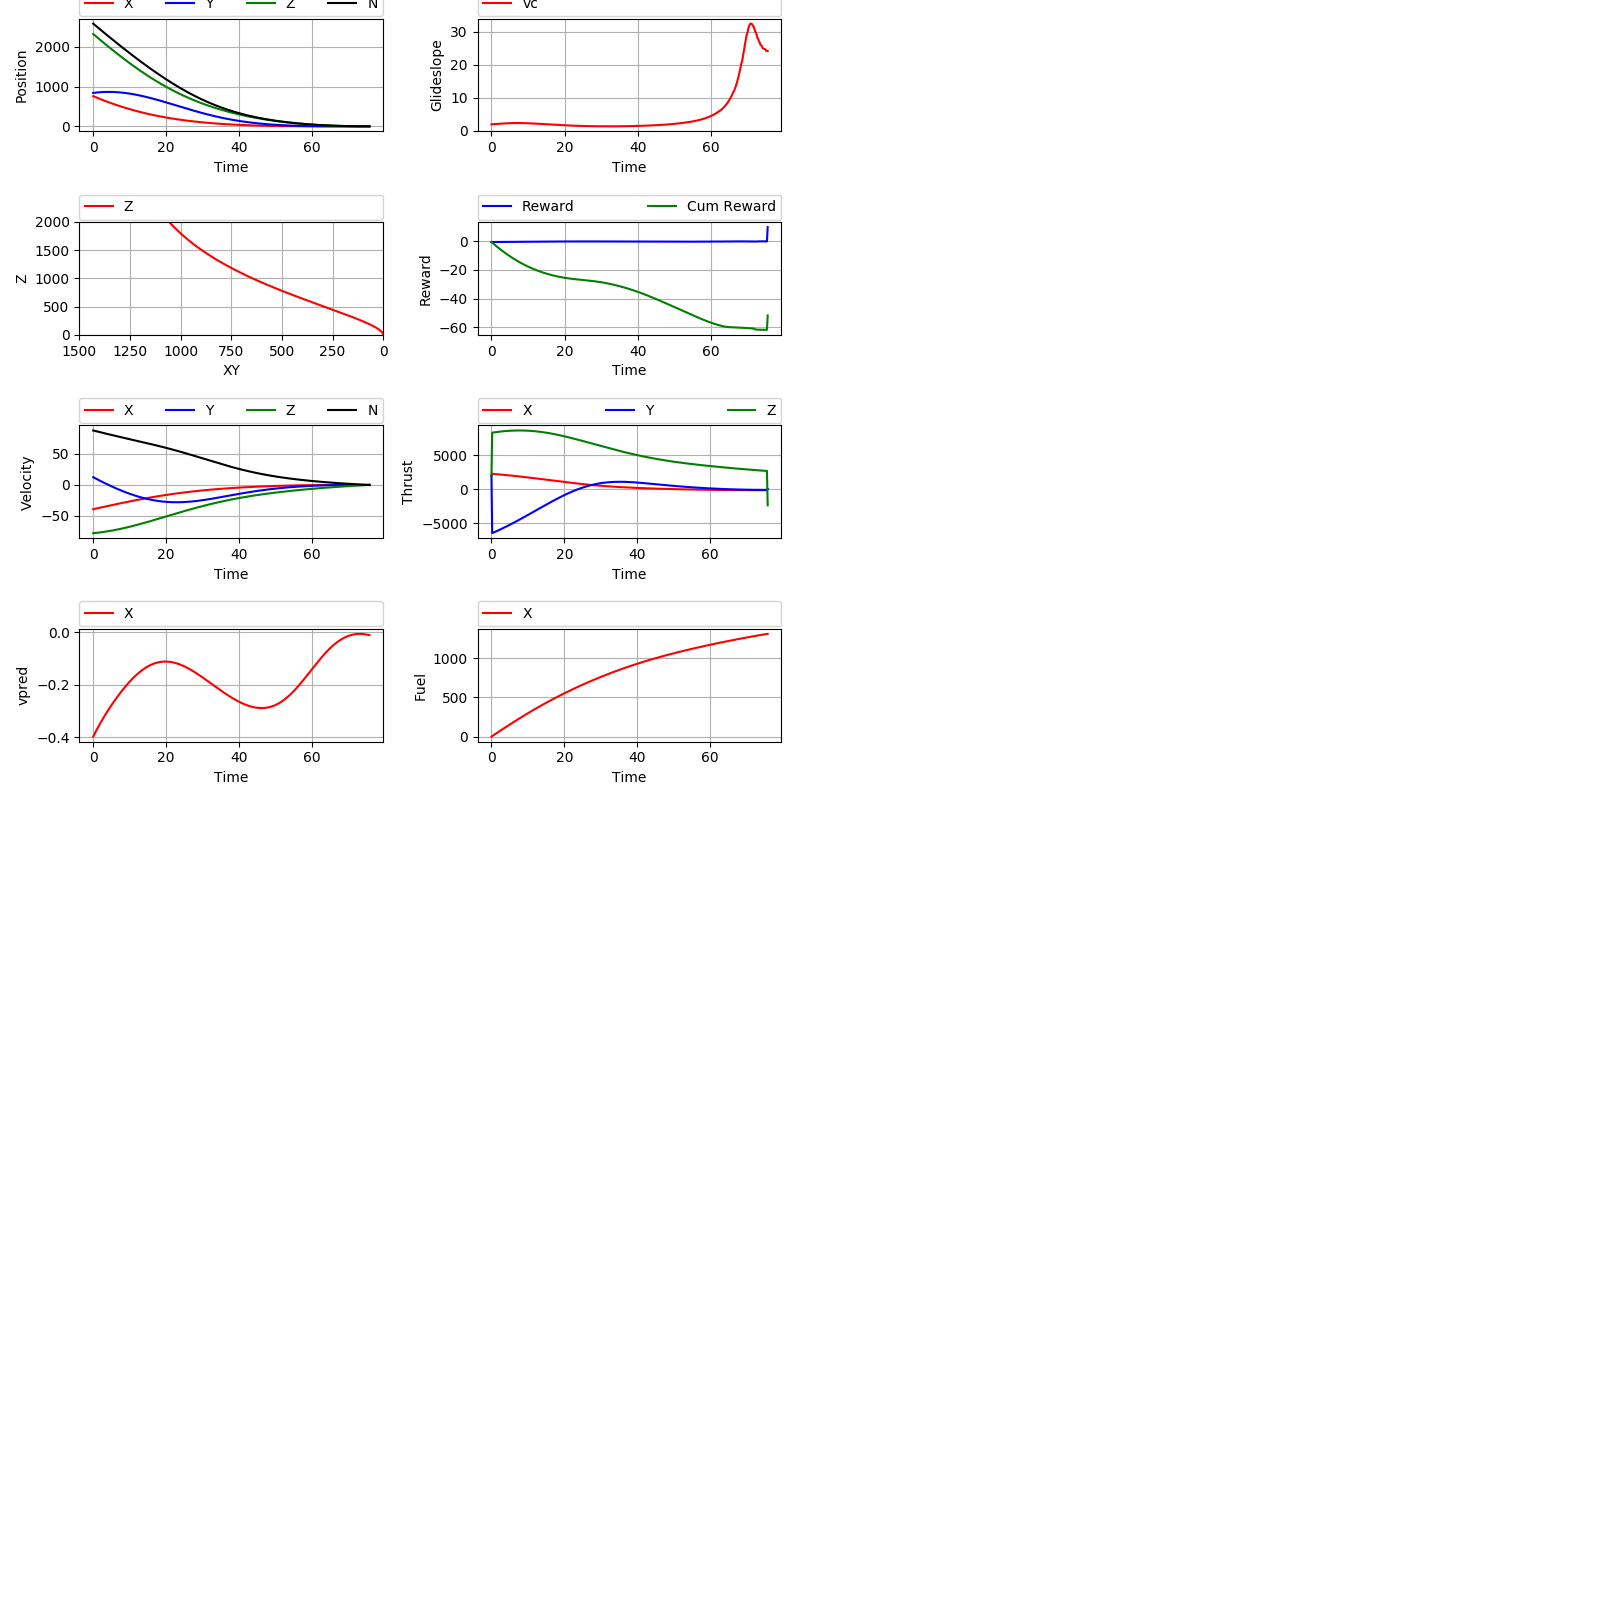

<IPython.core.display.Javascript object>


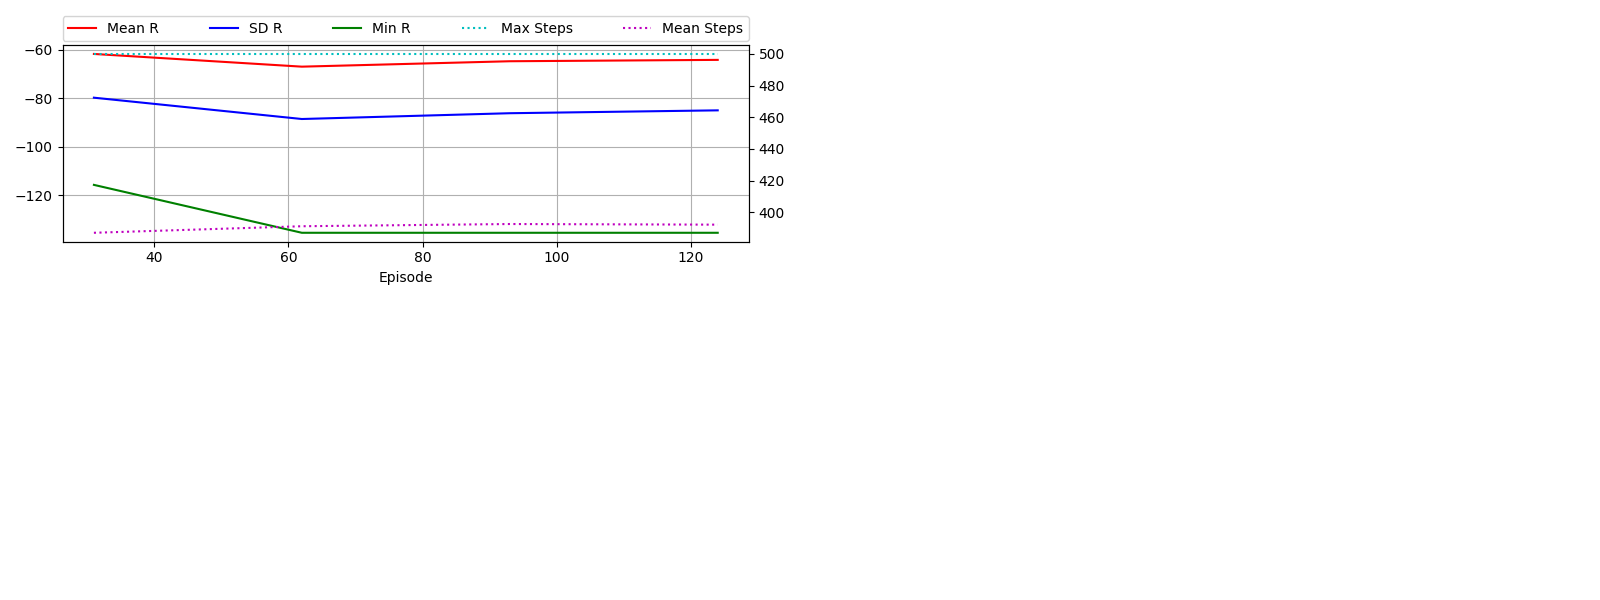

<IPython.core.display.Javascript object>


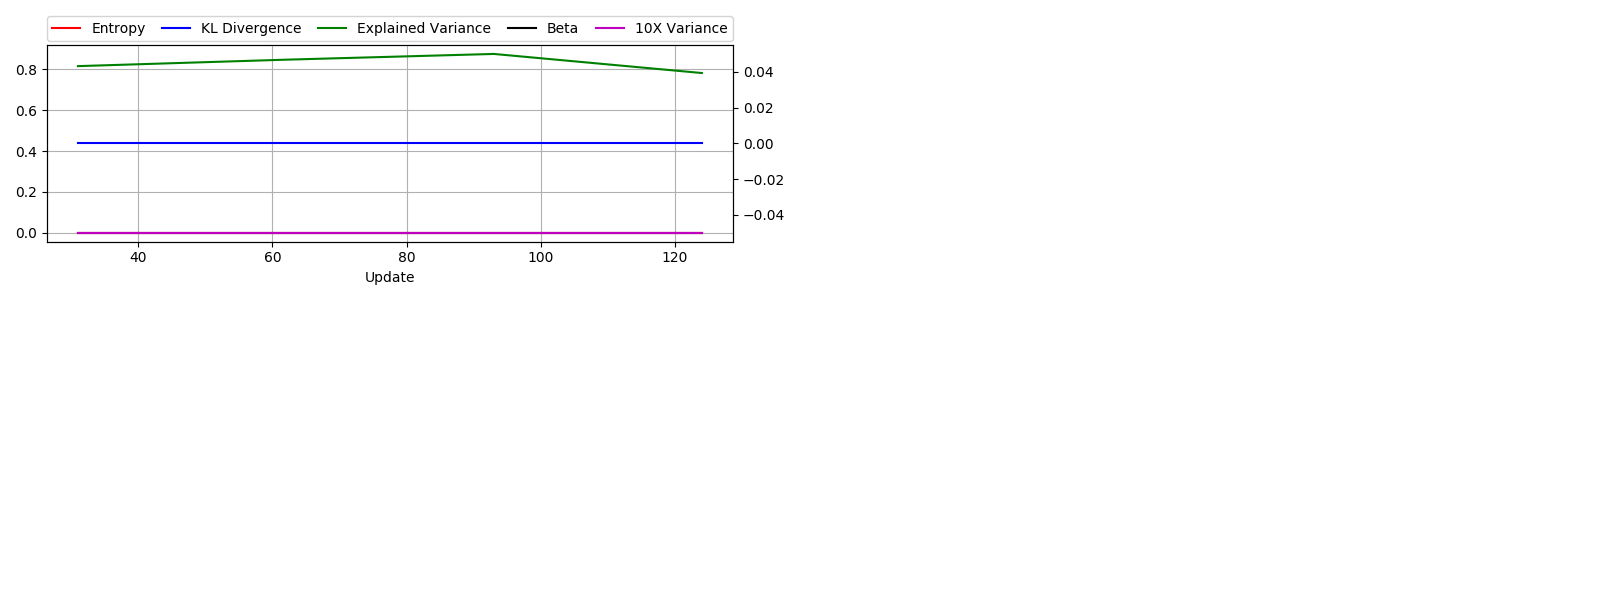

<IPython.core.display.Javascript object>


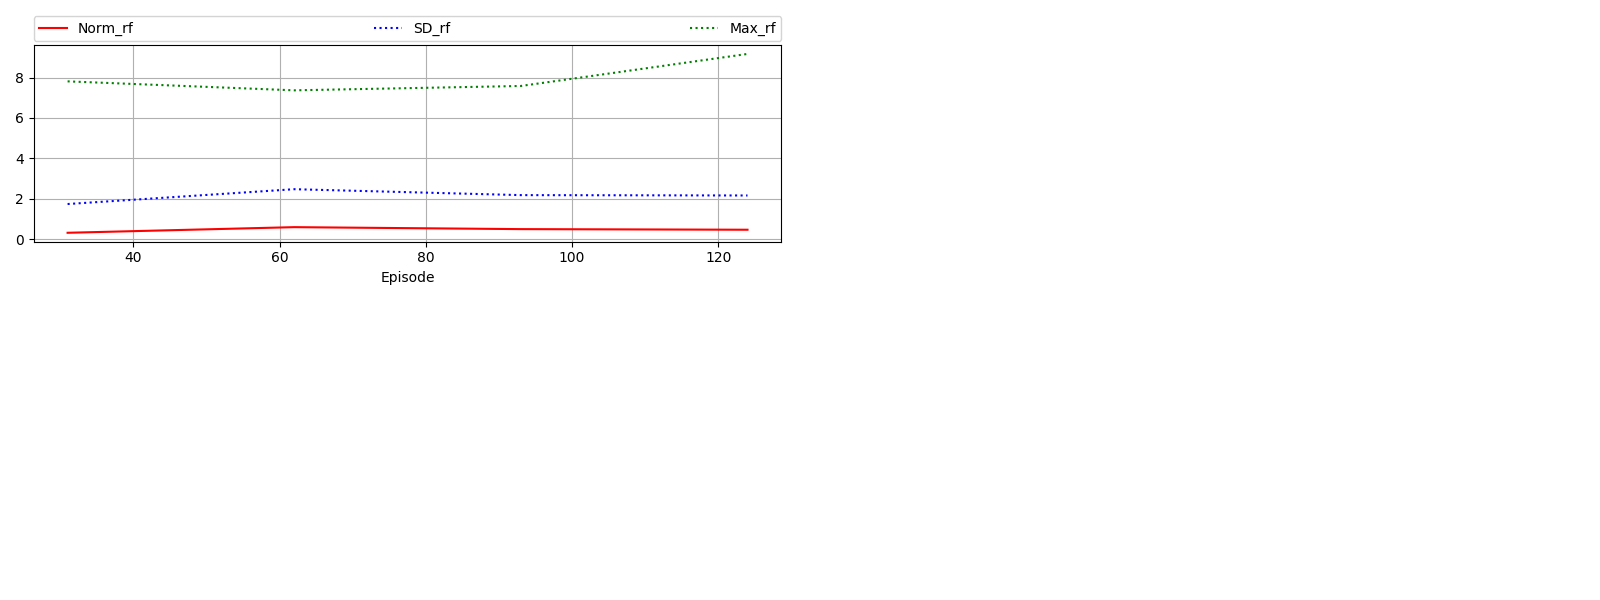

<IPython.core.display.Javascript object>


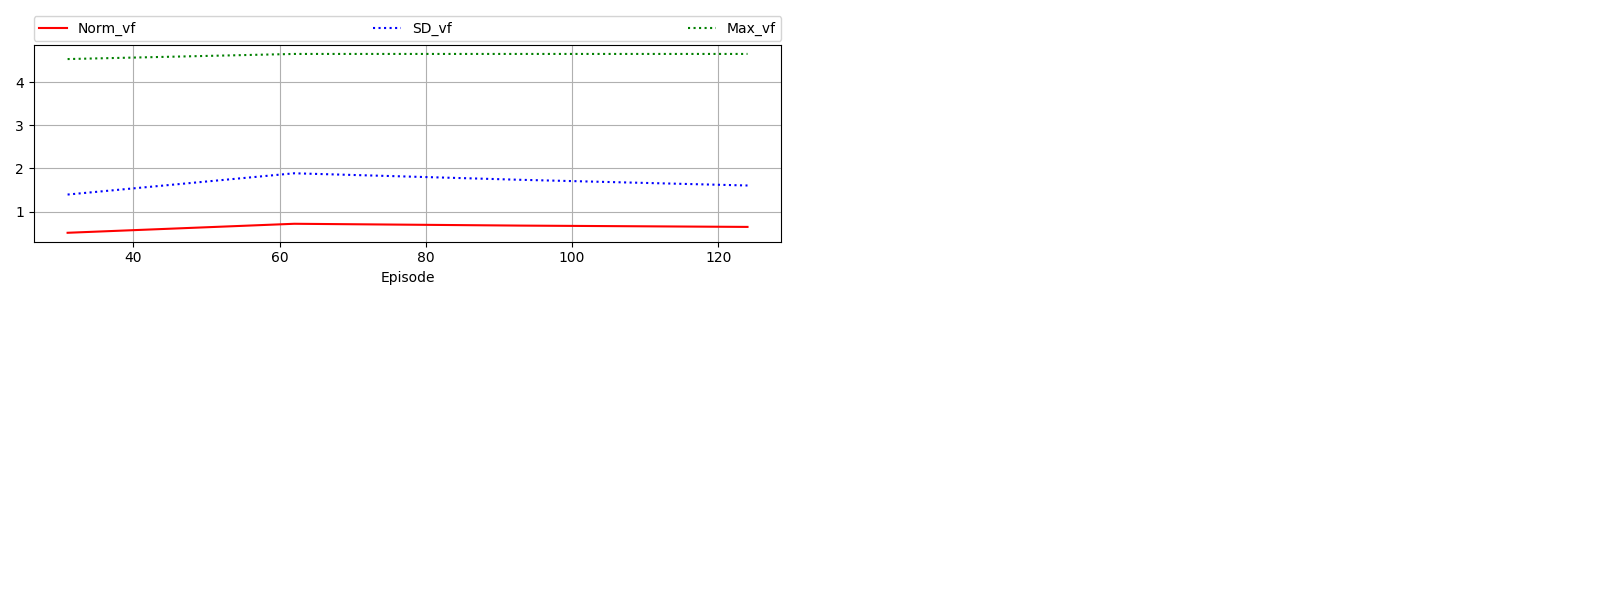

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
    adjust_apf_v0               :  True
Value Funtion
	xn_init: layer  Linear(in_features=6, out_features=60, bias=True)
	xn_init: layer  Linear(in_features=60, out_features=17, bias=True)
	xn_init: layer  Linear(in_features=17, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
	Clip Range:         0.5
	Shuffle :           True
	Batch Size :        256
	Max Grad Norm:      30
	Recurrent Steps:    1
	Rollout Limit:      1
Agent
*** SCALER WARMUP COMPLETE *** 
ValFun  Gradients: u/sd/Max/C Max/Max u/Max sd :   0.0314   0.0480   1.0232   1.0232   0.0314   0.0480
Update Cnt = 0    ET =     51.5   Stats:  Mean, Std, Min, Max
r_f      |     0.0    -0.0     0.3 |     0.0     0.1     1.4 |    -0.0    -0.3    -0.0 | 

KeyboardInterrupt: 

In [3]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from model import Model
from policy_drdv import Policy
from value_function import Value_function

import pcm_model_nets as model_nets
import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
dynamics_model.Isp /= 6
lander_model = Lander_model(apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15.)
lander_model.get_state_agent = lander_model.get_state_agent1
obs_dim = 6
act_dim = 3
recurrent_steps = 1

reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=100.0,print_every=10)

env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.05,0.05),
                           adjust_apf_v0=True,
                          downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70))
env.ic_gen.show()

arch = Arch()

policy = Policy(env)
value_function = Value_function(valfunc_nets.MLP1(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=True, batch_size=256, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
agent.train(10000)

# Test Policy 

In [4]:
policy.test_mode=True

env.test_policy_batch(agent,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |6015.67 |2666.51 |2000.00 |15000.00 |    34
glideslope | 8.619 |25.139 | 0.614 |2051.237 |    91
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.835 |   1.193 |   0.000 |   4.924
norm_rf  |     0.7 |     2.0 |     0.0 |     9.4
position |     0.0     0.0     0.7 |     0.1     0.1     2.0 |    -0.3    -0.3    -0.1 |     0.4     0.2     9.4
velocity |  -0.199  -0.003  -0.198 |   1.151   0.744   0.405 |  -4.073  -3.323  -1.424 |   4.242   2.958   1.142
fuel     |1383.11 |163.77 |1177.87 |1887.75
glideslope | 46.47 |153.63 |  6.73 |1572.19
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |5993.88 |2645.76 |2000.00 |15000.00 |   159
glideslope | 7.762 |20.648 | 0.526 |2051.237 |    91
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.739 |   1.098 |   0.000 |   4.924
norm_rf  |     0.6 |     1.8 |     0.0 |     9.4
position |

i :  1400
Cumulative Stats (mean,std,max,argmax)
thrust   |5946.67 |2648.04 |2000.00 |15000.00 |   721
glideslope | 7.756 |116.634 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.625 |   0.936 |   0.000 |   5.299
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
position |     0.0     0.0     0.4 |     0.0     0.0     1.5 |    -0.7    -0.4    -0.1 |     0.4     0.4    19.6
velocity |  -0.014  -0.016  -0.245 |   0.763   0.718   0.330 |  -4.682  -4.610  -1.856 |   4.740   4.556   1.535
fuel     |1358.36 |134.96 |1142.81 |1899.51
glideslope | 33.91 | 49.79 |  3.49 |1572.19
i :  1500
Cumulative Stats (mean,std,max,argmax)
thrust   |5946.09 |2647.44 |2000.00 |15000.00 |   721
glideslope | 7.752 |112.956 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.612 |   0.917 |   0.000 |   5.299
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
posi

i :  2700
Cumulative Stats (mean,std,max,argmax)
thrust   |5944.31 |2651.82 |2000.00 |15000.00 |   721
glideslope | 7.718 |103.668 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.613 |   0.934 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
position |     0.0     0.0     0.4 |     0.1     0.0     1.5 |    -0.7    -0.4    -0.1 |     0.4     0.4    19.6
velocity |  -0.013  -0.019  -0.244 |   0.749   0.719   0.332 |  -4.682  -4.610  -1.856 |   4.850   5.167   2.168
fuel     |1359.89 |133.74 |1134.55 |1899.51
glideslope | 40.17 |338.30 |  3.49 |17489.47
i :  2800
Cumulative Stats (mean,std,max,argmax)
thrust   |5944.29 |2653.35 |2000.00 |15000.00 |   721
glideslope | 7.725 |102.005 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.617 |   0.939 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
pos

i :  4000
Cumulative Stats (mean,std,max,argmax)
thrust   |5946.23 |2653.24 |2000.00 |15000.00 |   721
glideslope | 7.588 |86.070 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.625 |   0.950 |   0.000 |   5.389
norm_rf  |     0.4 |     1.6 |     0.0 |    19.6
position |     0.0     0.0     0.4 |     0.1     0.0     1.6 |    -0.7    -0.5    -0.1 |     0.5     0.4    19.6
velocity |  -0.012  -0.022  -0.241 |   0.752   0.747   0.333 |  -4.682  -4.626  -1.856 |   4.863   5.167   2.168
fuel     |1360.88 |135.46 |1134.55 |1899.51
glideslope | 38.23 |278.66 |  3.49 |17489.47
i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |5946.83 |2653.50 |2000.00 |15000.00 |   721
glideslope | 7.591 |85.056 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.628 |   0.954 |   0.000 |   5.389
norm_rf  |     0.4 |     1.6 |     0.0 |    19.6
posit

i :  5300
Cumulative Stats (mean,std,max,argmax)
thrust   |5945.22 |2649.63 |2000.00 |15000.00 |   721
glideslope | 7.586 |75.536 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.629 |   0.957 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
position |     0.0     0.0     0.4 |     0.1     0.0     1.5 |    -0.7    -0.5    -0.1 |     0.7     0.4    19.6
velocity |  -0.008  -0.015  -0.240 |   0.759   0.751   0.338 |  -4.704  -4.705  -1.856 |   4.863   5.167   2.168
fuel     |1361.40 |135.50 |1134.55 |1899.51
glideslope | 37.41 |243.06 |  3.29 |17489.47
i :  5400
Cumulative Stats (mean,std,max,argmax)
thrust   |5945.08 |2650.05 |2000.00 |15000.00 |   721
glideslope | 7.587 |74.932 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.627 |   0.953 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
posit

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |5944.88 |2649.73 |2000.00 |15000.00 |   721
glideslope | 7.551 |68.503 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.628 |   0.952 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
position |     0.0     0.0     0.4 |     0.1     0.0     1.5 |    -0.7    -0.5    -0.1 |     0.7     0.4    19.6
velocity |  -0.008  -0.015  -0.241 |   0.760   0.742   0.337 |  -4.926  -5.001  -1.856 |   4.863   5.167   2.451
fuel     |1361.34 |134.96 |1134.55 |1899.51
glideslope | 37.55 |220.11 |  3.29 |17489.47
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |5945.58 |2649.66 |2000.00 |15000.00 |   721
glideslope | 7.553 |68.043 | 0.456 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.625 |   0.948 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
posit

i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |5946.32 |2648.28 |2000.00 |15000.00 |   721
glideslope | 7.563 |63.464 | 0.436 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.615 |   0.937 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
position |     0.0     0.0     0.4 |     0.0     0.0     1.5 |    -0.7    -0.5    -0.1 |     0.7     0.4    19.6
velocity |  -0.007  -0.009  -0.242 |   0.742   0.733   0.330 |  -4.926  -5.001  -1.856 |   4.863   5.167   2.451
fuel     |1360.18 |133.79 |1134.55 |1899.51
glideslope | 37.59 |202.53 |  3.29 |17489.47
i :  8000
Cumulative Stats (mean,std,max,argmax)
thrust   |5945.79 |2648.80 |2000.00 |15000.00 |   721
glideslope | 7.560 |63.173 | 0.436 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.616 |   0.938 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
posit

i :  9200
Cumulative Stats (mean,std,max,argmax)
thrust   |5942.75 |2650.68 |2000.00 |15000.00 |   721
glideslope | 7.551 |59.334 | 0.436 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.622 |   0.945 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
position |     0.0     0.0     0.4 |     0.0     0.0     1.5 |    -0.7    -0.5    -0.1 |     0.7     0.4    19.6
velocity |  -0.004  -0.013  -0.243 |   0.749   0.740   0.334 |  -4.926  -5.076  -1.856 |   4.863   5.167   2.451
fuel     |1360.86 |134.11 |1134.55 |1899.51
glideslope | 37.24 |188.16 |  3.12 |17489.47
i :  9300
Cumulative Stats (mean,std,max,argmax)
thrust   |5942.89 |2651.27 |2000.00 |15000.00 |   721
glideslope | 7.559 |59.059 | 0.436 |79334.597 |   788
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.624 |   0.948 |   0.000 |   5.389
norm_rf  |     0.4 |     1.5 |     0.0 |    19.6
posit